In [11]:
# ============================================================================
# IMPORTS
# ============================================================================
import os
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
from shutil import rmtree  # optional cleanup

# Fermitools
import gt_apps as my_apps
from UnbinnedAnalysis import UnbinnedObs, UnbinnedAnalysis
from LATSourceModel import SourceList

# NumPy compatibility
if not hasattr(np, "float"):
    np.float = float

print("Imports complete")

# ============================================================================
# TARGET DEFINITIONS (read MGF candidates)
# ============================================================================
FERMI_EPOCH = Time('2001-01-01T00:00:00', scale='utc')

def utc_to_met(t0, time_kind="auto"):
    """
    Return Fermi MET (float seconds) from either:
      - UTC string / astropy.Time  -> convert to MET (float)
      - numeric (int/float)        -> assume already MET (keep fractional)
    time_kind: 'auto' | 'utc' | 'met'
    """
    if time_kind == "met":
        return float(t0)
    if time_kind == "utc":
        t = t0 if isinstance(t0, Time) else Time(str(t0), scale='utc', format='iso')
        return (t - FERMI_EPOCH).to_value('sec')
    if isinstance(t0, (int, float)):
        return float(t0)
    if isinstance(t0, Time):
        return (t0 - FERMI_EPOCH).to_value('sec')
    return (Time(str(t0), scale='utc', format='iso') - FERMI_EPOCH).to_value('sec')

def build_target(name, ra_deg, dec_deg, t0, dt_s, time_kind="auto"):
    """
    Build target dict supporting UTC or MET.
      dt_s = total window length (float seconds). Here we use [t0, t0+dt].
    """
    t0_met = float(utc_to_met(t0, time_kind=time_kind))
    dt_s = float(dt_s)
    return {
        "name": str(name),
        "ra": float(ra_deg),
        "dec": float(dec_deg),
        "t0_utc": (str(t0) if time_kind != "met" else None),
        "t0_met": t0_met,
        "dt": dt_s,
        "tmin": t0_met,
        "tmax": t0_met + dt_s,
    }

# ---- read candidate list
MGF_LIST = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger") / "GBM_eMGF_candidates.txt"
df = pd.read_csv(MGF_LIST, sep=r"\s+", comment="#")

# ---- window length (total seconds, e.g. 500 s)
del_T = 10000.0

# ---- build targets (t0 already MET)
targets = [
    build_target(
        row.GRB_name,
        float(row.gal_ra_deg),
        float(row.gal_dec_deg),
        float(row.MET_trig_time),
        del_T,
        time_kind="met",
    )
    for _, row in df.iterrows()
]

print(f"Loaded {len(targets)} MGF targets from {MGF_LIST}")
print(targets)




# ============================================================================
# CONFIGURATION (paths & analysis knobs)
# ============================================================================
BASE = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger")
DATA_DIR = BASE                               # GRB_* subfolders live here
WORK_DIR = BASE / "MGF_Stacking_Analysis"     # results go here
WORK_DIR.mkdir(parents=True, exist_ok=True)

OVERWRITE_RUN = True

EMIN = 100.0       # MeV
EMAX = 100000.0     # 100 GeV
ROI  = 12.0        # deg
ZMIN = 0.0  # needed by gtselect wrapper
ZMAX = 100.0
EVCLASS = 8        # Transient
EVTYPE  = 3        # FRONT+BACK
IRFS    = "P8R3_TRANSIENT020E_V3"
INDEX   = -2.0     # PowerLaw2 fixed photon index

# Diffuse and catalog models (from your directory + FERMI_DIR iso)
CATALOG  = str(BASE / "gll_psc_v35.fit")
GAL_DIFF = str(BASE / "gll_iem_v07_cut.fits")
ISO_DIFF = os.path.join(
    os.environ.get("FERMI_DIR", ""),
    "refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt"
)

# Shared flux grid
FLUX_GRID = np.concatenate(([0.0], np.logspace(-11, -3, 150)))
print(f"Flux grid: {len(FLUX_GRID)} points from {FLUX_GRID[1]:.2e} to {FLUX_GRID[-1]:.2e}")

# ============================================================================
# FILE DISCOVERY
# ============================================================================
def find_ft1_ft2(data_dir: Path):
    """Return FT1 (events) and FT2 (spacecraft) from a GRB_* folder."""
    ft1_patterns = [
        "L*_EV00.fits", "*_EV00.fits", "*_EV*.fits",
        "L*_PH00.fits", "*_PH00.fits", "*_PH*.fits",
        "gll_ft1_tr_*.fit", "gll_ft1_*.fit",
    ]
    ft2_patterns = [
        "L*_SC00.fits", "*_SC00.fits", "*_SC*.fits",
        "spacecraft*.fits", "*_SC.fits",
    ]
    def first_match(patterns):
        for pat in patterns:
            files = sorted(data_dir.glob(pat))
            if files:
                return str(files[0])
        return None
    ft1 = first_match(ft1_patterns)
    ft2 = first_match(ft2_patterns)
    if not ft1 or not ft2:
        raise FileNotFoundError(f"Missing FT1/FT2 in {data_dir}. Found FT1={ft1}, FT2={ft2}")
    return ft1, ft2

# ============================================================================
# UTILITY
# ============================================================================
def _clean_work_dirs():
    if OVERWRITE_RUN and WORK_DIR.exists():
        for d in WORK_DIR.iterdir():
            if d.is_dir():
                try:
                    rmtree(d)
                except Exception:
                    pass

def ensure_nonempty_gti(gti_fits):
    with fits.open(gti_fits) as hdul:
        if "GTI" not in hdul or len(hdul["GTI"].data) == 0:
            raise RuntimeError("Empty GTI")

# ============================================================================
# PROFILE-LIKELIHOOD HELPERS
# ============================================================================
def _freeze_all_params(like):
    """Freeze EVERYTHING in the model (catalog + diffuse)."""
    npars = len(like.model.params)
    for k in range(npars):
        try:
            like.freeze(k)
        except:
            pass

def _free_diffuse_norms(like):
    """Free ONLY diffuse normalizations (Galactic + isotropic)."""
    for s in like.sourceNames():
        sl = s.lower()
        if ('iso' in sl) or ('gll_iem' in sl) or ('gal' in sl and '4fgl' not in sl):
            try:
                spec = like.model[s].funcs['Spectrum']
                for pname in ('Prefactor','Normalization','Value','norm','ScaleFactor'):
                    try:
                        spec.getParam(pname).setFree(True)
                        break
                    except:
                        continue
            except:
                continue
    like.syncSrcParams()

def _prepare_transient_pl2(like, src):
    """Fix spectral shape; keep only Integral scanned."""
    spec = like.model[src].funcs['Spectrum']
    for nm in ('Index', 'LowerLimit', 'UpperLimit'):
        try:
            spec.getParam(nm).setFree(False)
        except:
            pass
    P = spec.getParam('Integral')
    lo, hi = P.getBounds()
    if lo != 0.0:
        try:
            P.setBounds(0.0, hi)
        except:
            pass
    P.setFree(False)
    like.syncSrcParams(src)

def _set_flux(like, flux, src):
    spec = like.model[src].funcs['Spectrum']
    P = spec.getParam('Integral')
    sc = P.getScale() or 1.0
    P.setValue(max(0.0, float(flux)) / sc)
    P.setFree(False)
    like.syncSrcParams(src)



def gtselect_filter_events(ifl, gtselect_outfile, evclass, evtype, ra, dec, rad,
                           tmin, tmax, emin, emax, zmin, zmax):
    my_apps.filter['infile']  = str(ifl)
    my_apps.filter['outfile'] = str(gtselect_outfile)
    my_apps.filter['evclass'] = int(evclass)
    my_apps.filter['evtype']  = int(evtype)
    my_apps.filter['ra']      = float(ra)
    my_apps.filter['dec']     = float(dec)
    my_apps.filter['rad']     = float(rad)
    my_apps.filter['tmin']    = float(tmin)
    my_apps.filter['tmax']    = float(tmax)
    my_apps.filter['emin']    = float(emin)
    my_apps.filter['emax']    = float(emax)
    my_apps.filter['zmin']    = float(zmin)
    my_apps.filter['zmax']    = float(zmax)
    print("[gtselect]", my_apps.filter.command())
    my_apps.filter.run()
    return gtselect_outfile


def gtmaketime_events(scfile, evfile, gtmaketime_ofl, ra_src, dec_src, roi_deg, zmax_deg):
    # limb cut via GTIs: ANGSEP <= (zmax - ROI)
    filt = ("(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&"
            f"(ANGSEP(RA_ZENITH,DEC_ZENITH,{ra_src:.6f},{dec_src:.6f})<={zmax_deg - roi_deg:.1f})")
    my_apps.maketime['scfile']   = str(scfile)
    my_apps.maketime['sctable']  = "SC_DATA"
    my_apps.maketime['filter']   = filt
    my_apps.maketime['roicut']   = "no"
    my_apps.maketime['evfile']   = str(evfile)
    my_apps.maketime['evtable']  = "EVENTS"
    my_apps.maketime['outfile']  = str(gtmaketime_ofl)
    print("[gtmktime]", my_apps.maketime.command())
    my_apps.maketime.run()
    return gtmaketime_ofl


def gt_ltcube(scfile, evfile, ltcube_outfile):
    my_apps.expCube['evfile']    = str(evfile)
    my_apps.expCube['scfile']    = str(scfile)
    my_apps.expCube['outfile']   = str(ltcube_outfile)
    my_apps.expCube['zmax']      = 180.0        # limb already handled in GTIs
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz']     = 1.0
    print("[gtltcube]", my_apps.expCube.command())
    my_apps.expCube.run()
    return ltcube_outfile


def exp_map(expmap_input_ifl, scfile, ltcube_file, expmap_outfile, irf):
    my_apps.expMap['evfile']    = str(expmap_input_ifl)
    my_apps.expMap['scfile']    = str(scfile)
    my_apps.expMap['expcube']   = str(ltcube_file)
    my_apps.expMap['outfile']   = str(expmap_outfile)
    my_apps.expMap['irfs']      = str(irf)
    my_apps.expMap['srcrad']    = 24.0
    my_apps.expMap['nlong']     = 48
    my_apps.expMap['nlat']      = 48
    my_apps.expMap['nenergies'] = 20
    print("[gtexpmap]", my_apps.expMap.command())
    my_apps.expMap.run()
    return expmap_outfile


def diff_rsp(diffrsp_evfile, scfile, srcmdl, irf):
    my_apps.diffResps['evfile']  = str(diffrsp_evfile)
    my_apps.diffResps['scfile']  = str(scfile)
    my_apps.diffResps['srcmdl']  = str(srcmdl)
    my_apps.diffResps['irfs']    = str(irf)
    my_apps.diffResps['evtable'] = "EVENTS"
    my_apps.diffResps['sctable'] = "SC_DATA"
    print("[gtdiffrsp]", my_apps.diffResps.command())
    my_apps.diffResps.run()





def build_model_and_diffresp(work_dir, gti_file, ft2, ra, dec, src_name):
    """Build XML with ALL catalog sources frozen; add GRB; compute diffuse response."""
    xml = work_dir / "model.xml"

    sl = SourceList(
        catalog_file=CATALOG,
        ROI=str(gti_file),
        output_name="base.xml",
        write_directory=str(work_dir)
    )

    # Do NOT auto-free any catalog source (hosts at same position must stay frozen).
    sl.make_model(
        galactic_file=GAL_DIFF,
        isotropic_file=ISO_DIFF,
        free_radius=1e-6,      # effectively zero
        sigma_to_free=1e9,     # effectively never
        norms_free_only=True,
        variable_free=False
    )

    # Add the transient (real GRB name) with fixed shape; we scan 'Integral'.
    pl2 = {
        "model": "PowerLaw2",
        "Integral": 1e-9,
        "Integral_free": True,
        "Index": INDEX,
        "Index_free": False,
        "LowerLimit": EMIN,
        "LowerLimit_free": False,
        "UpperLimit": EMAX,
        "UpperLimit_free": False
    }
    sl.add_point_source(
        src_name,
        RA=ra, DEC=dec,
        spectrum_model=pl2,
        new_model_name=str(xml),
        overwrite=True
    )

    # Diffuse response on the GTI-ed event file
    diff_rsp(diffrsp_evfile=gti_file, scfile=ft2, srcmdl=xml, irf=IRFS)
    return str(xml)



# ============================================================================
# SINGLE EVENT ANALYSIS
# ============================================================================
def analyze_event(target):
    """Complete analysis for single event with strict freeze + profile scan."""
    name = target["name"]
    print(f"\n{'='*50}\nAnalyzing {name}\n{'='*50}")

    data_dir = DATA_DIR / name
    work_dir = WORK_DIR / name
    work_dir.mkdir(parents=True, exist_ok=True)

    try:
        ft1, ft2 = find_ft1_ft2(data_dir)
    except Exception as e:
        print(f"  Skip: missing data ({e})")
        return None

    filtered = work_dir / "filtered.fits"
    gti_file = work_dir / "gti.fits"
    ltcube   = work_dir / "ltcube.fits"
    expmap   = work_dir / "expmap.fits"

    try:
        # 1) gtselect with your exact cuts (incl. zmin)
        gtselect_filter_events(
            ifl=ft1,
            gtselect_outfile=filtered,
            evclass=EVCLASS, evtype=EVTYPE,
            ra=target["ra"], dec=target["dec"], rad=ROI,
            tmin=target["tmin"], tmax=target["tmax"],
            emin=EMIN, emax=EMAX,
            zmin=ZMIN, zmax=ZMAX
        )

        # quick event count
        with fits.open(filtered) as hdul:
            n_events = len(hdul["EVENTS"].data) if "EVENTS" in hdul else 0
        if n_events == 0:
            print("  Skip: no events in ROI after gtselect")
            return None
        print(f"  {n_events} events selected")

        # 2) gtmktime with limb-angle GTI cut
        gtmaketime_events(
            scfile=ft2, evfile=filtered, gtmaketime_ofl=gti_file,
            ra_src=target["ra"], dec_src=target["dec"],
            roi_deg=ROI, zmax_deg=ZMAX
        )
        ensure_nonempty_gti(gti_file)
        # ---- compute ontime (sum of GTIs) and total livetime ----
        with fits.open(gti_file) as hdul:
            gtab = hdul["GTI"].data
            ontime = np.sum(gtab["STOP"] - gtab["START"])

        # Read livetime fraction from FT2 within same MET range
        from astropy.table import Table
        ft2tab = Table.read(ft2, hdu=1)
        mask = (ft2tab["START"] >= target["tmin"]) & (ft2tab["STOP"] <= target["tmax"])
        livetime = np.sum(ft2tab["LIVETIME"][mask])

        print(f"  Ontime (GTI): {ontime:.2f} s, Livetime (FT2): {livetime:.2f} s, Fraction = {livetime/ontime:.3f}")

        # 3) gtltcube (zmax=180 here since limb handled in GTIs)
        gt_ltcube(scfile=ft2, evfile=gti_file, ltcube_outfile=ltcube)

        # 4) gtexpmap (24°, 48x48, 20 energies)
        exp_map(
            expmap_input_ifl=gti_file, scfile=ft2, ltcube_file=ltcube,
            expmap_outfile=expmap, irf=IRFS
        )

        # 5) model: catalog fully frozen; add GRB; run gtdiffrsp
        xml = build_model_and_diffresp(
            work_dir, gti_file, ft2,
            target["ra"], target["dec"],
            src_name=name
        )

        # Likelihood object
        obs  = UnbinnedObs(str(gti_file), ft2, expMap=str(expmap),
                           expCube=str(ltcube), irfs=IRFS)
        like = UnbinnedAnalysis(obs, srcModel=str(xml), optimizer="NEWMINUIT")

        if name not in like.sourceNames():
            print("  Skip: GRB source not in model")
            return None

        # Strict freeze: lock *everything*, then free ONLY diffuse norms.
        _freeze_all_params(like)
        _free_diffuse_norms(like)
        _prepare_transient_pl2(like, name)  # only 'Integral' is scanned

        # Null hypothesis
        _set_flux(like, 0.0, name)
        like.fit(verbosity=0, covar=False)
        logL_null = -float(like())

        # Profile scan over shared flux grid
        print(f"  Scanning {len(FLUX_GRID)} flux points...")
        logL_with = np.empty_like(FLUX_GRID)
        for i, F in enumerate(FLUX_GRID):
            if i % 30 == 0:
                print(f"    {i}/{len(FLUX_GRID)}")
            _set_flux(like, F, name)
            like.fit(verbosity=0, covar=False)
            logL_with[i] = -float(like())

        # Save profile (overwrite)
        profile_file = work_dir / "profile.npz"
        np.savez(profile_file,
                 flux_grid=FLUX_GRID,
                 logL_with=logL_with,
                 logL_null=logL_null,
                 status="ok")
        print(f"  Profile saved: {profile_file}")
        return str(profile_file)

    except Exception as e:
        print(f"  Skip: error ({e})")
        return None
# STACKING
# ============================================================================
def stack_profiles(profile_files):
    if not profile_files:
        print("No profiles to stack")
        return None

    print(f"\n{'='*50}\nStacking {len(profile_files)} profiles\n{'='*50}")

    TS_list = []
    for pf in profile_files:
        d = np.load(pf, allow_pickle=True)
        status = "ok"
        if "status" in d:
            sarr = np.array(d["status"])
            status = sarr.item() if sarr.shape == () else sarr[0]
        if status != "ok":
            print(f"  Skip: {pf} (status={status})")
            continue
        F = d["flux_grid"]
        if not np.allclose(F, FLUX_GRID):
            print(f"  Skip: grid mismatch {pf}")
            continue
        logL_with = d["logL_with"]
        logL_null = float(d["logL_null"])
        TS_i = 2.0 * (logL_with - logL_null)
        TS_list.append(TS_i)

    if not TS_list:
        print("No valid profiles")
        return None

    TS_stacked = np.sum(TS_list, axis=0)
    idx_max = np.argmax(TS_stacked)
    TS_max  = TS_stacked[idx_max]
    F_best  = FLUX_GRID[idx_max]
    print(f"\nMaximum TS: {TS_max:.2f}")
    print(f"Best fit flux: {F_best:.2e} ph/cm²/s")

    TS_threshold = TS_max - 2.71
    UL95 = None

    if idx_max < len(TS_stacked) - 1:
        F_right = FLUX_GRID[idx_max:]
        TS_right = TS_stacked[idx_max:]
        TS_right = np.minimum.accumulate(TS_right)  # enforce monotonic decrease
        below = TS_right <= TS_threshold
        if np.any(below):
            idx = np.argmax(below)
            if idx > 0:
                f1, f2 = F_right[idx-1], F_right[idx]
                ts1, ts2 = TS_right[idx-1], TS_right[idx]
                w = (TS_threshold - ts1) / (ts2 - ts1)
                UL95 = 10**(np.log10(f1) + w * (np.log10(f2) - np.log10(f1)))

    if UL95:
        print(f"95% Upper Limit: {UL95:.2e} ph/cm²/s")
    else:
        print("95% UL not reached in flux range")

    return {
        'flux_grid': FLUX_GRID,
        'TS_stacked': TS_stacked,
        'TS_max': TS_max,
        'F_best': F_best,
        'TS_threshold': TS_threshold,
        'UL95': UL95,
        'n_stacked': len(TS_list)
    }

# ============================================================================
# PLOTTING
# ============================================================================
def plot_stacked_profile(result):
    fig, ax = plt.subplots(figsize=(8, 5))
    F  = result['flux_grid']
    TS = result['TS_stacked']

    mask = F > 0
    ax.semilogx(F[mask], TS[mask], 'b-', lw=2, label='Stacked TS')
    ax.axvline(result['F_best'], color='green', ls='--', alpha=0.7,
               label=f"Best fit: {result['F_best']:.2e}")
    ax.axhline(result['TS_max'], color='green', ls='--', alpha=0.7,
               label=f"Max TS: {result['TS_max']:.1f}")
    ax.axhline(result['TS_threshold'], color='red', ls='--', alpha=0.7,
               label='95% CL: TS - 2.71')
    if result['UL95']:
        ax.axvline(result['UL95'], color='red', ls=':', lw=2,
                   label=f"95% UL: {result['UL95']:.2e} [ph cm$^{-2}$ s$^{-1}$]")
        ax.plot(result['UL95'], result['TS_threshold'], 'ro', markersize=8)

    ax.set_xlabel('Flux [ph cm$^{-2}$ s$^{-1}$]')
    ax.set_ylabel('Test Statistic')
    ax.set_title(f"Stacked Profile Likelihood ({result['n_stacked']} events)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.set_ylim(-5, 10)
    plt.tight_layout()
    plt.savefig(WORK_DIR / "stacked_profile.png", dpi=150)
    plt.show()



Imports complete
Loaded 7 MGF targets from /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GBM_eMGF_candidates.txt
[{'name': 'GRB_231115A', 'ra': 148.968458, 'dec': 69.679703, 't0_utc': None, 't0_met': 721755386.0, 'dt': 10000.0, 'tmin': 721755386.0, 'tmax': 721765386.0}, {'name': 'GRB_200415A', 'ra': 11.888058, 'dec': -25.2888, 't0_utc': None, 't0_met': 608633290.0, 'dt': 10000.0, 'tmin': 608633290.0, 'tmax': 608643290.0}, {'name': 'GRB_180128A', 'ra': 11.888058, 'dec': -25.2888, 't0_utc': None, 't0_met': 538809001.0, 'dt': 10000.0, 'tmin': 538809001.0, 'tmax': 538819001.0}, {'name': 'GRB_120616A', 'ra': 56.702142, 'dec': 68.096106, 't0_utc': None, 't0_met': 361552012.0, 'dt': 10000.0, 'tmin': 361552012.0, 'tmax': 361562012.0}, {'name': 'GRB_200423A', 'ra': 308.71805, 'dec': 60.153678, 't0_utc': None, 't0_met': 609342856.0, 'dt': 10000.0, 'tmin': 609342856.0, 'tmax': 609352856.0}, {'name': 'GRB_231024A', 'ra': 11.888058, 'dec': -25.2888, 't0_utc': None, 't0_met': 719846439.0, '

/var/folders/st/ng23bqyd59ndbk5_qmpyq8rr0000gn/T/ipykernel_54273/2910983782.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, "float"):


FERMI LAT STACKING ANALYSIS (MGF candidates)

Analyzing GRB_231115A
[gtselect] time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721755386.0 tmax=721765386.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721755386.0 tmax=721765386.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes

......................!
real 0.19
user 0.14
sys 0.04
[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_SC00.fits sctable="SC_DATA" ex

.......................!
real 0.20
user 0.14
sys 0.05
[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_180128A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_180128A/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_180128A/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_180128A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" e

......................!
real 0.19
user 0.13
sys 0.04
[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_120616A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_120616A/L250924145213039FD35840_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_120616A/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_120616A/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_120616A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_120616A/L250924145213039FD35840_SC00.fits sctable="SC_DATA" ex

.....................!
real 0.19
user 0.14
sys 0.04
[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_200423A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200423A/L250924145324039FD35856_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_200423A/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_200423A/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_200423A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_200423A/L250924145324039FD35856_SC00.fits sctable="SC_DATA" exp

......................!
real 0.20
user 0.15
sys 0.04
[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231024A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231024A/L250924145416039FD35828_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231024A/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231024A/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231024A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231024A/L250924145416039FD35828_SC00.fits sctable="SC_DATA" ex

Working on file /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_081213A/L251013184128F357373F31_SC00.fits
......................!
real 0.21
user 0.15
sys 0.05
[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_081213A/gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_081213A/L251013184128F357373F31_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_081213A/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_081213A/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_081213A/gti.fits evtable="EVENTS" scfile=/Use

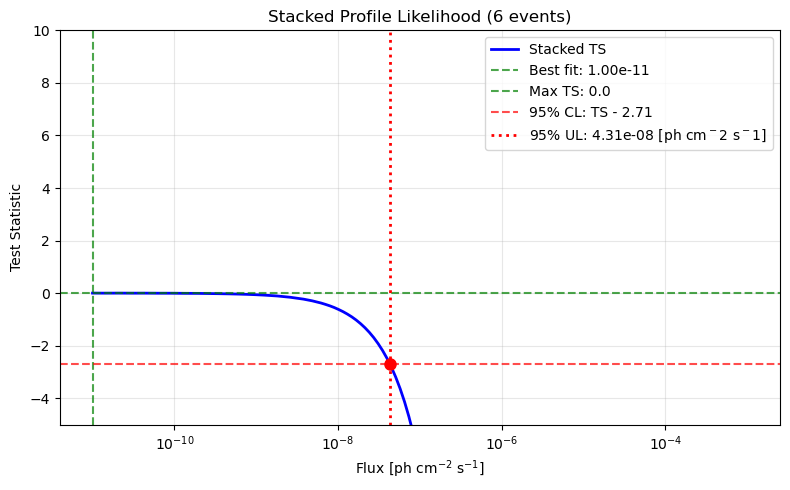


Results saved to /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis


In [12]:
def main():
    print("="*60)
    print("FERMI LAT STACKING ANALYSIS (MGF candidates)")
    print("="*60)

    _clean_work_dirs()

    # exclude one or more names here
    exclude = {"GRB_200415A"}
    todo = [t for t in targets if t["name"] not in exclude]

    profiles = []
    for target in todo:
        p = analyze_event(target)
        if p:
            profiles.append(p)

    print(f"\nSuccessful analyses: {len(profiles)}/{len(todo)}")
    if len(profiles) < 2:
        print("Not enough profiles for stacking")
        return None

    result = stack_profiles(profiles)
    if result:
        plot_stacked_profile(result)
        np.savez(WORK_DIR / "stacking_results.npz", **result)
        print(f"\nResults saved to {WORK_DIR}")
    return result

if __name__ == "__main__":
    res = main()


# Stack pre-burst intervals or post bursts intervals

Add a big Offset

Imports complete
Loaded 7 MGF targets from /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GBM_eMGF_candidates.txt
[{'name': 'GRB_231115A', 'ra': 148.968458, 'dec': 69.679703, 't0_utc': None, 't0_met': 721745386.0, 'dt': 500.0, 'tmin': 721755386.0, 'tmax': 721755886.0}, {'name': 'GRB_200415A', 'ra': 11.888058, 'dec': -25.2888, 't0_utc': None, 't0_met': 608623290.0, 'dt': 500.0, 'tmin': 608633290.0, 'tmax': 608633790.0}, {'name': 'GRB_180128A', 'ra': 11.888058, 'dec': -25.2888, 't0_utc': None, 't0_met': 538799001.0, 'dt': 500.0, 'tmin': 538809001.0, 'tmax': 538809501.0}, {'name': 'GRB_120616A', 'ra': 56.702142, 'dec': 68.096106, 't0_utc': None, 't0_met': 361542012.0, 'dt': 500.0, 'tmin': 361552012.0, 'tmax': 361552512.0}, {'name': 'GRB_200423A', 'ra': 308.71805, 'dec': 60.153678, 't0_utc': None, 't0_met': 609332856.0, 'dt': 500.0, 'tmin': 609342856.0, 'tmax': 609343356.0}, {'name': 'GRB_231024A', 'ra': 11.888058, 'dec': -25.2888, 't0_utc': None, 't0_met': 719836439.0, 'dt': 500.0

/var/folders/st/ng23bqyd59ndbk5_qmpyq8rr0000gn/T/ipykernel_54273/4128990136.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, "float"):


Done.
real 0.26
user 0.23
sys 0.02
  17 events selected
[gtmktime] time -p gtmktime scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_SC00.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&(ANGSEP(RA_ZENITH,DEC_ZENITH,148.968458,69.679703)<=88.0)" roicut=no evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis_Offset/GRB_231115A/filtered.fits evtable="EVENTS" outfile="/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis_Offset/GRB_231115A/gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtmktime scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_SC00.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&(ANGSEP(RA_ZENITH,DEC_ZENITH,148.968458,69.679703)<=88.0)"

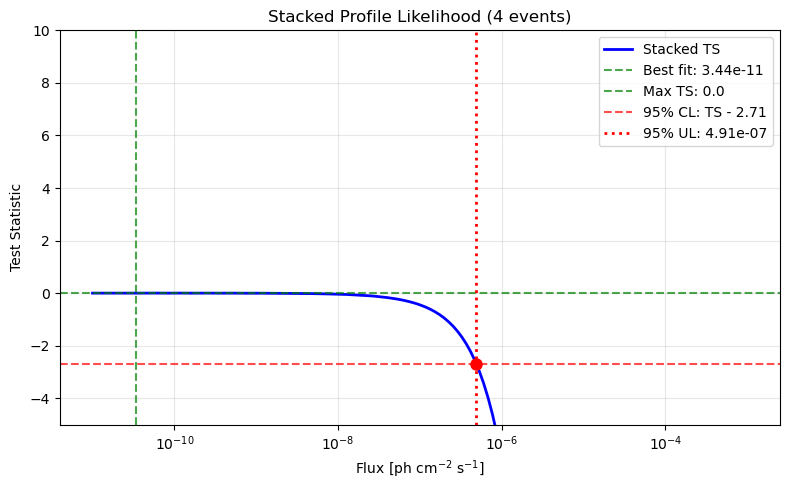


Results saved to /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis_Offset


In [3]:
# ============================================================================
# IMPORTS
# ============================================================================
import os
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
from shutil import rmtree  # optional cleanup

# Fermitools
import gt_apps as my_apps
from UnbinnedAnalysis import UnbinnedObs, UnbinnedAnalysis
from LATSourceModel import SourceList

# NumPy compatibility
if not hasattr(np, "float"):
    np.float = float

print("Imports complete")

# ============================================================================
# TARGET DEFINITIONS (read MGF candidates)
# ============================================================================
FERMI_EPOCH = Time('2001-01-01T00:00:00', scale='utc')

def utc_to_met(t0, time_kind="auto"):
    """
    Return Fermi MET (float seconds) from either:
      - UTC string / astropy.Time  -> convert to MET (float)
      - numeric (int/float)        -> assume already MET (keep fractional)
    time_kind: 'auto' | 'utc' | 'met'
    """
    if time_kind == "met":
        return float(t0)
    if time_kind == "utc":
        t = t0 if isinstance(t0, Time) else Time(str(t0), scale='utc', format='iso')
        return (t - FERMI_EPOCH).to_value('sec')
    if isinstance(t0, (int, float)):
        return float(t0)
    if isinstance(t0, Time):
        return (t0 - FERMI_EPOCH).to_value('sec')
    return (Time(str(t0), scale='utc', format='iso') - FERMI_EPOCH).to_value('sec')

def build_target(name, ra_deg, dec_deg, t0, dt_s, time_kind="auto"):
    """
    Build target dict supporting UTC or MET.
      dt_s = total window length (float seconds). Here we use [t0, t0+dt].
    """
    t0_met = float(utc_to_met(t0, time_kind=time_kind))
    dt_s = float(dt_s)
    return {
        "name": str(name),
        "ra": float(ra_deg),
        "dec": float(dec_deg),
        "t0_utc": (str(t0) if time_kind != "met" else None),
        "t0_met": t0_met - 10000,     #10k seconds before the trigger
        "dt": dt_s,
        "tmin": t0_met,
        "tmax": t0_met + dt_s,
    }

# ---- read candidate list
MGF_LIST = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger") / "GBM_eMGF_candidates.txt"
df = pd.read_csv(MGF_LIST, sep=r"\s+", comment="#")

# ---- window length (total seconds, e.g. 500 s)
del_T = 500.0

# ---- build targets (t0 already MET)
targets = [
    build_target(
        row.GRB_name,
        float(row.gal_ra_deg),
        float(row.gal_dec_deg),
        float(row.MET_trig_time),
        del_T,
        time_kind="met",
    )
    for _, row in df.iterrows()
]

print(f"Loaded {len(targets)} MGF targets from {MGF_LIST}")
print(targets)




# ============================================================================
# CONFIGURATION (paths & analysis knobs)
# ============================================================================
BASE = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger")
DATA_DIR = BASE                               # GRB_* subfolders live here
WORK_DIR = BASE / "MGF_Stacking_Analysis_Offset"     # results go here
WORK_DIR.mkdir(parents=True, exist_ok=True)

OVERWRITE_RUN = True

EMIN = 100.0       # MeV
EMAX = 10000.0     # MeV
ROI  = 12.0        # deg
ZMIN = 0.0  # needed by gtselect wrapper
ZMAX = 100.0
EVCLASS = 8        # Transient
EVTYPE  = 3        # FRONT+BACK
IRFS    = "P8R3_TRANSIENT020E_V3"
INDEX   = -2.0     # PowerLaw2 fixed photon index

# Diffuse and catalog models (from your directory + FERMI_DIR iso)
CATALOG  = str(BASE / "gll_psc_v35.fit")
GAL_DIFF = str(BASE / "gll_iem_v07_cut.fits")
ISO_DIFF = os.path.join(
    os.environ.get("FERMI_DIR", ""),
    "refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt"
)
import numpy as np

# ---------------------------
# Constants
# ---------------------------
GEV_TO_ERG = 1.602176634e-3  # 1 GeV in erg

def K_from_photon_flux(Fph, gamma, Emin, Emax):
    """
    Solve for K in dN/dE = K E^gamma (E in GeV),
    given integrated photon flux Fph over [Emin, Emax] (ph cm^-2 s^-1).
    """
    if np.isclose(gamma, -1.0):
        # Integral of E^-1 dE = ln(E)
        integral = np.log(Emax / Emin)
    else:
        integral = (Emax**(gamma + 1) - Emin**(gamma + 1)) / (gamma + 1)
    return Fph / integral  # units: ph cm^-2 s^-1 GeV^-1

def energy_flux_from_K(K, gamma, Emin, Emax):
    """
    Compute energy flux FE = ∫ E (dN/dE) dE over [Emin, Emax],
    returning erg cm^-2 s^-1.
    """
    # ∫ E * K E^gamma dE = K ∫ E^(gamma+1) dE
    if np.isclose(gamma, -2.0):
        # gamma+2 = 0 -> integral of E^-1
        integral = np.log(Emax / Emin)
    else:
        integral = (Emax**(gamma + 2) - Emin**(gamma + 2)) / (gamma + 2)
    FE_GeV = K * integral  # GeV cm^-2 s^-1
    return FE_GeV * GEV_TO_ERG

def Eiso_from_energy_flux(FE, dt, d_mpc):
    """
    E_iso = 4π d^2 (FE * dt)
    d_mpc in Mpc, FE in erg cm^-2 s^-1, dt in s.
    """
    MPC_TO_CM = 3.085677581491367e24
    d_cm = d_mpc * MPC_TO_CM
    return 4.0 * np.pi * d_cm**2 * (FE * dt)

# ---------------------------
# Inputs from your stacking scan
# ---------------------------
Fph_UL_0p1_100 = 4.91e-7     # ph cm^-2 s^-1  (from your pasted log)
gamma = -2.0

Emin_ph, Emax_ph = 0.1, 100.0   # photon-flux integration range (GeV)
Emin_E,  Emax_E  = 0.1, 10.0    # desired energy-flux range (GeV)

dt = 1000.0      # seconds (use 100, 1000, 10000 as needed)
d_mpc = 3.5      # your adopted stacked distance (update if needed)

# ---------------------------
# Conversion
# ---------------------------
K = K_from_photon_flux(Fph_UL_0p1_100, gamma, Emin_ph, Emax_ph)
FE_0p1_10 = energy_flux_from_K(K, gamma, Emin_E, Emax_E)
Eiso = Eiso_from_energy_flux(FE_0p1_10, dt, d_mpc)

print(f"Assumed dN/dE = K E^gamma with E in GeV")
print(f"gamma = {gamma:.2f}")
print(f"K = {K:.4e} ph cm^-2 s^-1 GeV^-1")
print(f"Energy flux (0.1–10 GeV) = {FE_0p1_10:.4e} erg cm^-2 s^-1")
print(f"E_LAT,iso (dt={dt:.0f}s, d={d_mpc:.2f} Mpc) = {Eiso:.4e} erg")

# Shared flux grid
FLUX_GRID = np.concatenate(([0.0], np.logspace(-11, -3, 150)))
print(f"Flux grid: {len(FLUX_GRID)} points from {FLUX_GRID[1]:.2e} to {FLUX_GRID[-1]:.2e}")

# ============================================================================
# FILE DISCOVERY
# ============================================================================
def find_ft1_ft2(data_dir: Path):
    """Return FT1 (events) and FT2 (spacecraft) from a GRB_* folder."""
    ft1_patterns = [
        "L*_EV00.fits", "*_EV00.fits", "*_EV*.fits",
        "L*_PH00.fits", "*_PH00.fits", "*_PH*.fits",
        "gll_ft1_tr_*.fit", "gll_ft1_*.fit",
    ]
    ft2_patterns = [
        "L*_SC00.fits", "*_SC00.fits", "*_SC*.fits",
        "spacecraft*.fits", "*_SC.fits",
    ]
    def first_match(patterns):
        for pat in patterns:
            files = sorted(data_dir.glob(pat))
            if files:
                return str(files[0])
        return None
    ft1 = first_match(ft1_patterns)
    ft2 = first_match(ft2_patterns)
    if not ft1 or not ft2:
        raise FileNotFoundError(f"Missing FT1/FT2 in {data_dir}. Found FT1={ft1}, FT2={ft2}")
    return ft1, ft2

# ============================================================================
# UTILITY
# ============================================================================
def _clean_work_dirs():
    if OVERWRITE_RUN and WORK_DIR.exists():
        for d in WORK_DIR.iterdir():
            if d.is_dir():
                try:
                    rmtree(d)
                except Exception:
                    pass

def ensure_nonempty_gti(gti_fits):
    with fits.open(gti_fits) as hdul:
        if "GTI" not in hdul or len(hdul["GTI"].data) == 0:
            raise RuntimeError("Empty GTI")

# ============================================================================
# PROFILE-LIKELIHOOD HELPERS
# ============================================================================
def _freeze_all_params(like):
    """Freeze EVERYTHING in the model (catalog + diffuse)."""
    npars = len(like.model.params)
    for k in range(npars):
        try:
            like.freeze(k)
        except:
            pass

def _free_diffuse_norms(like):
    """Free ONLY diffuse normalizations (Galactic + isotropic)."""
    for s in like.sourceNames():
        sl = s.lower()
        if ('iso' in sl) or ('gll_iem' in sl) or ('gal' in sl and '4fgl' not in sl):
            try:
                spec = like.model[s].funcs['Spectrum']
                for pname in ('Prefactor','Normalization','Value','norm','ScaleFactor'):
                    try:
                        spec.getParam(pname).setFree(True)
                        break
                    except:
                        continue
            except:
                continue
    like.syncSrcParams()

def _prepare_transient_pl2(like, src):
    """Fix spectral shape; keep only Integral scanned."""
    spec = like.model[src].funcs['Spectrum']
    for nm in ('Index', 'LowerLimit', 'UpperLimit'):
        try:
            spec.getParam(nm).setFree(False)
        except:
            pass
    P = spec.getParam('Integral')
    lo, hi = P.getBounds()
    if lo != 0.0:
        try:
            P.setBounds(0.0, hi)
        except:
            pass
    P.setFree(False)
    like.syncSrcParams(src)

def _set_flux(like, flux, src):
    spec = like.model[src].funcs['Spectrum']
    P = spec.getParam('Integral')
    sc = P.getScale() or 1.0
    P.setValue(max(0.0, float(flux)) / sc)
    P.setFree(False)
    like.syncSrcParams(src)



def gtselect_filter_events(ifl, gtselect_outfile, evclass, evtype, ra, dec, rad,
                           tmin, tmax, emin, emax, zmin, zmax):
    my_apps.filter['infile']  = str(ifl)
    my_apps.filter['outfile'] = str(gtselect_outfile)
    my_apps.filter['evclass'] = int(evclass)
    my_apps.filter['evtype']  = int(evtype)
    my_apps.filter['ra']      = float(ra)
    my_apps.filter['dec']     = float(dec)
    my_apps.filter['rad']     = float(rad)
    my_apps.filter['tmin']    = float(tmin)
    my_apps.filter['tmax']    = float(tmax)
    my_apps.filter['emin']    = float(emin)
    my_apps.filter['emax']    = float(emax)
    my_apps.filter['zmin']    = float(zmin)
    my_apps.filter['zmax']    = float(zmax)
    print("[gtselect]", my_apps.filter.command())
    my_apps.filter.run()
    return gtselect_outfile


def gtmaketime_events(scfile, evfile, gtmaketime_ofl, ra_src, dec_src, roi_deg, zmax_deg):
    # limb cut via GTIs: ANGSEP <= (zmax - ROI)
    filt = ("(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&"
            f"(ANGSEP(RA_ZENITH,DEC_ZENITH,{ra_src:.6f},{dec_src:.6f})<={zmax_deg - roi_deg:.1f})")
    my_apps.maketime['scfile']   = str(scfile)
    my_apps.maketime['sctable']  = "SC_DATA"
    my_apps.maketime['filter']   = filt
    my_apps.maketime['roicut']   = "no"
    my_apps.maketime['evfile']   = str(evfile)
    my_apps.maketime['evtable']  = "EVENTS"
    my_apps.maketime['outfile']  = str(gtmaketime_ofl)
    print("[gtmktime]", my_apps.maketime.command())
    my_apps.maketime.run()
    return gtmaketime_ofl


def gt_ltcube(scfile, evfile, ltcube_outfile):
    my_apps.expCube['evfile']    = str(evfile)
    my_apps.expCube['scfile']    = str(scfile)
    my_apps.expCube['outfile']   = str(ltcube_outfile)
    my_apps.expCube['zmax']      = 180.0        # limb already handled in GTIs
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz']     = 1.0
    print("[gtltcube]", my_apps.expCube.command())
    my_apps.expCube.run()
    return ltcube_outfile


def exp_map(expmap_input_ifl, scfile, ltcube_file, expmap_outfile, irf):
    my_apps.expMap['evfile']    = str(expmap_input_ifl)
    my_apps.expMap['scfile']    = str(scfile)
    my_apps.expMap['expcube']   = str(ltcube_file)
    my_apps.expMap['outfile']   = str(expmap_outfile)
    my_apps.expMap['irfs']      = str(irf)
    my_apps.expMap['srcrad']    = 24.0
    my_apps.expMap['nlong']     = 48
    my_apps.expMap['nlat']      = 48
    my_apps.expMap['nenergies'] = 20
    print("[gtexpmap]", my_apps.expMap.command())
    my_apps.expMap.run()
    return expmap_outfile


def diff_rsp(diffrsp_evfile, scfile, srcmdl, irf):
    my_apps.diffResps['evfile']  = str(diffrsp_evfile)
    my_apps.diffResps['scfile']  = str(scfile)
    my_apps.diffResps['srcmdl']  = str(srcmdl)
    my_apps.diffResps['irfs']    = str(irf)
    my_apps.diffResps['evtable'] = "EVENTS"
    my_apps.diffResps['sctable'] = "SC_DATA"
    print("[gtdiffrsp]", my_apps.diffResps.command())
    my_apps.diffResps.run()





def build_model_and_diffresp(work_dir, gti_file, ft2, ra, dec, src_name):
    """Build XML with ALL catalog sources frozen; add GRB; compute diffuse response."""
    xml = work_dir / "model.xml"

    sl = SourceList(
        catalog_file=CATALOG,
        ROI=str(gti_file),
        output_name="base.xml",
        write_directory=str(work_dir)
    )

    # Do NOT auto-free any catalog source (hosts at same position must stay frozen).
    sl.make_model(
        galactic_file=GAL_DIFF,
        isotropic_file=ISO_DIFF,
        free_radius=1e-6,      # effectively zero
        sigma_to_free=1e9,     # effectively never
        norms_free_only=True,
        variable_free=False
    )

    # Add the transient (real GRB name) with fixed shape; we scan 'Integral'.
    pl2 = {
        "model": "PowerLaw2",
        "Integral": 1e-9,
        "Integral_free": True,
        "Index": INDEX,
        "Index_free": False,
        "LowerLimit": EMIN,
        "LowerLimit_free": False,
        "UpperLimit": EMAX,
        "UpperLimit_free": False
    }
    sl.add_point_source(
        src_name,
        RA=ra, DEC=dec,
        spectrum_model=pl2,
        new_model_name=str(xml),
        overwrite=True
    )

    # Diffuse response on the GTI-ed event file
    diff_rsp(diffrsp_evfile=gti_file, scfile=ft2, srcmdl=xml, irf=IRFS)
    return str(xml)



# ============================================================================
# SINGLE EVENT ANALYSIS
# ============================================================================
def analyze_event(target):
    """Complete analysis for single event with strict freeze + profile scan."""
    name = target["name"]
    print(f"\n{'='*50}\nAnalyzing {name}\n{'='*50}")

    data_dir = DATA_DIR / name
    work_dir = WORK_DIR / name
    work_dir.mkdir(parents=True, exist_ok=True)

    try:
        ft1, ft2 = find_ft1_ft2(data_dir)
    except Exception as e:
        print(f"  Skip: missing data ({e})")
        return None

    filtered = work_dir / "filtered.fits"
    gti_file = work_dir / "gti.fits"
    ltcube   = work_dir / "ltcube.fits"
    expmap   = work_dir / "expmap.fits"

    try:
        # 1) gtselect with your exact cuts (incl. zmin)
        gtselect_filter_events(
            ifl=ft1,
            gtselect_outfile=filtered,
            evclass=EVCLASS, evtype=EVTYPE,
            ra=target["ra"], dec=target["dec"], rad=ROI,
            tmin=target["tmin"], tmax=target["tmax"],
            emin=EMIN, emax=EMAX,
            zmin=ZMIN, zmax=ZMAX
        )

        # quick event count
        with fits.open(filtered) as hdul:
            n_events = len(hdul["EVENTS"].data) if "EVENTS" in hdul else 0
        if n_events == 0:
            print("  Skip: no events in ROI after gtselect")
            return None
        print(f"  {n_events} events selected")

        # 2) gtmktime with limb-angle GTI cut
        gtmaketime_events(
            scfile=ft2, evfile=filtered, gtmaketime_ofl=gti_file,
            ra_src=target["ra"], dec_src=target["dec"],
            roi_deg=ROI, zmax_deg=ZMAX
        )
        ensure_nonempty_gti(gti_file)

        # 3) gtltcube (zmax=180 here since limb handled in GTIs)
        gt_ltcube(scfile=ft2, evfile=gti_file, ltcube_outfile=ltcube)

        # 4) gtexpmap (24°, 48x48, 20 energies)
        exp_map(
            expmap_input_ifl=gti_file, scfile=ft2, ltcube_file=ltcube,
            expmap_outfile=expmap, irf=IRFS
        )

        # 5) model: catalog fully frozen; add GRB; run gtdiffrsp
        xml = build_model_and_diffresp(
            work_dir, gti_file, ft2,
            target["ra"], target["dec"],
            src_name=name
        )

        # Likelihood object
        obs  = UnbinnedObs(str(gti_file), ft2, expMap=str(expmap),
                           expCube=str(ltcube), irfs=IRFS)
        like = UnbinnedAnalysis(obs, srcModel=str(xml), optimizer="NEWMINUIT")

        if name not in like.sourceNames():
            print("  Skip: GRB source not in model")
            return None

        # Strict freeze: lock *everything*, then free ONLY diffuse norms.
        _freeze_all_params(like)
        _free_diffuse_norms(like)
        _prepare_transient_pl2(like, name)  # only 'Integral' is scanned

        # Null hypothesis
        _set_flux(like, 0.0, name)
        like.fit(verbosity=0, covar=False)
        logL_null = -float(like())

        # Profile scan over shared flux grid
        print(f"  Scanning {len(FLUX_GRID)} flux points...")
        logL_with = np.empty_like(FLUX_GRID)
        for i, F in enumerate(FLUX_GRID):
            if i % 30 == 0:
                print(f"    {i}/{len(FLUX_GRID)}")
            _set_flux(like, F, name)
            like.fit(verbosity=0, covar=False)
            logL_with[i] = -float(like())

        # Save profile (overwrite)
        profile_file = work_dir / "profile.npz"
        np.savez(profile_file,
                 flux_grid=FLUX_GRID,
                 logL_with=logL_with,
                 logL_null=logL_null,
                 status="ok")
        print(f"  Profile saved: {profile_file}")
        return str(profile_file)

    except Exception as e:
        print(f"  Skip: error ({e})")
        return None
# STACKING
# ============================================================================
def stack_profiles(profile_files):
    if not profile_files:
        print("No profiles to stack")
        return None

    print(f"\n{'='*50}\nStacking {len(profile_files)} profiles\n{'='*50}")

    TS_list = []
    for pf in profile_files:
        d = np.load(pf, allow_pickle=True)
        status = "ok"
        if "status" in d:
            sarr = np.array(d["status"])
            status = sarr.item() if sarr.shape == () else sarr[0]
        if status != "ok":
            print(f"  Skip: {pf} (status={status})")
            continue
        F = d["flux_grid"]
        if not np.allclose(F, FLUX_GRID):
            print(f"  Skip: grid mismatch {pf}")
            continue
        logL_with = d["logL_with"]
        logL_null = float(d["logL_null"])
        TS_i = 2.0 * (logL_with - logL_null)
        TS_list.append(TS_i)

    if not TS_list:
        print("No valid profiles")
        return None

    TS_stacked = np.sum(TS_list, axis=0)
    idx_max = np.argmax(TS_stacked)
    TS_max  = TS_stacked[idx_max]
    F_best  = FLUX_GRID[idx_max]
    print(f"\nMaximum TS: {TS_max:.2f}")
    print(f"Best fit flux: {F_best:.2e} ph/cm²/s")

    TS_threshold = TS_max - 2.71
    UL95 = None

    if idx_max < len(TS_stacked) - 1:
        F_right = FLUX_GRID[idx_max:]
        TS_right = TS_stacked[idx_max:]
        TS_right = np.minimum.accumulate(TS_right)  # enforce monotonic decrease
        below = TS_right <= TS_threshold
        if np.any(below):
            idx = np.argmax(below)
            if idx > 0:
                f1, f2 = F_right[idx-1], F_right[idx]
                ts1, ts2 = TS_right[idx-1], TS_right[idx]
                w = (TS_threshold - ts1) / (ts2 - ts1)
                UL95 = 10**(np.log10(f1) + w * (np.log10(f2) - np.log10(f1)))

    if UL95:
        print(f"95% Upper Limit: {UL95:.2e} ph/cm²/s")
    else:
        print("95% UL not reached in flux range")

    return {
        'flux_grid': FLUX_GRID,
        'TS_stacked': TS_stacked,
        'TS_max': TS_max,
        'F_best': F_best,
        'TS_threshold': TS_threshold,
        'UL95': UL95,
        'n_stacked': len(TS_list)
    }

# ============================================================================
# PLOTTING
# ============================================================================
def plot_stacked_profile(result):
    fig, ax = plt.subplots(figsize=(8, 5))
    F  = result['flux_grid']
    TS = result['TS_stacked']

    mask = F > 0
    ax.semilogx(F[mask], TS[mask], 'b-', lw=2, label='Stacked TS')
    ax.axvline(result['F_best'], color='green', ls='--', alpha=0.7,
               label=f"Best fit: {result['F_best']:.2e}")
    ax.axhline(result['TS_max'], color='green', ls='--', alpha=0.7,
               label=f"Max TS: {result['TS_max']:.1f}")
    ax.axhline(result['TS_threshold'], color='red', ls='--', alpha=0.7,
               label='95% CL: TS - 2.71')
    if result['UL95']:
        ax.axvline(result['UL95'], color='red', ls=':', lw=2,
                   label=f"95% UL: {result['UL95']:.2e}")
        ax.plot(result['UL95'], result['TS_threshold'], 'ro', markersize=8)

    ax.set_xlabel('Flux [ph cm$^{-2}$ s$^{-1}$]')
    ax.set_ylabel('Test Statistic')
    ax.set_title(f"Stacked Profile Likelihood ({result['n_stacked']} events)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.set_ylim(-5, 10)
    plt.tight_layout()
    plt.savefig(WORK_DIR / "stacked_profile.png", dpi=150)
    plt.show()




def main():
    print("="*60)
    print("FERMI LAT STACKING ANALYSIS (MGF candidates)")
    print("="*60)

    _clean_work_dirs()

    # exclude one or more names here
    exclude = {"GRB_200415A"}
    todo = [t for t in targets if t["name"] not in exclude]

    profiles = []
    for target in todo:
        p = analyze_event(target)
        if p:
            profiles.append(p)

    print(f"\nSuccessful analyses: {len(profiles)}/{len(todo)}")
    if len(profiles) < 2:
        print("Not enough profiles for stacking")
        return None

    result = stack_profiles(profiles)
    if result:
        plot_stacked_profile(result)
        np.savez(WORK_DIR / "stacking_results.npz", **result)
        print(f"\nResults saved to {WORK_DIR}")
    return result

if __name__ == "__main__":
    res = main()


In [4]:
# ============================================================
# 1) which targets were stacked & their ontime
# ============================================================
from astropy.io import fits
from astropy.table import Table
from pathlib import Path

def _profile_ok(npz_path):
    try:
        d = np.load(npz_path, allow_pickle=True)
        s = d["status"] if "status" in d else "ok"
        if isinstance(s, np.ndarray): s = s.item()
        return s == "ok"
    except Exception:
        return False

def stacked_targets_with_ontime(targets, work_dir=WORK_DIR):
    out = []
    for tg in targets:
        name = tg["name"]
        w = Path(work_dir)/name
        gti = w/"gti.fits"
        prof = w/"profile.npz"
        if gti.exists() and _profile_ok(prof):
            with fits.open(gti) as hd:
                starts = hd["GTI"].data["START"].astype(float)
                stops  = hd["GTI"].data["STOP"].astype(float)
                ontime = float(np.sum(stops - starts))
            out.append((tg, ontime))
    print("Stacked:", [t[0]["name"] for t in out])
    return out  # list of (target_dict, ontime_s)

# ============================================================
# 2) utilities for simple background window selection
#    (a) full FT1 span, (b) full-span quality+limb GTIs,
#    (c) choose a prior GTI long enough, (d) make 1-interval GTI
# ============================================================
def ft1_time_span(ft1_path):
    with fits.open(ft1_path) as hd:
        times = hd["EVENTS"].data["TIME"].astype(float)
        return float(np.min(times)), float(np.max(times))

def make_fullspan_gti(ft1, ft2, ra, dec, roi, zmax, out_ev, out_gti):
    """Build GTIs across the full FT1 time span with the same quality+limb cuts."""
    tmin, tmax = ft1_time_span(ft1)
    # select events covering the full span (same ROI and energy cuts you use)
    gtselect_filter_events(
        ifl=ft1, gtselect_outfile=out_ev,
        evclass=EVCLASS, evtype=EVTYPE,
        ra=ra, dec=dec, rad=roi,
        tmin=tmin, tmax=tmax,
        emin=EMIN, emax=EMAX,
        zmin=ZMIN, zmax=ZMAX
    )
    # apply your standard mktime filter to derive GTIs over the full span
    gtmaketime_events(
        scfile=ft2, evfile=out_ev, gtmaketime_ofl=out_gti,
        ra_src=ra, dec_src=dec, roi_deg=roi, zmax_deg=zmax
    )
    ensure_nonempty_gti(out_gti)
    return str(out_gti)

def choose_prior_gti_at_least(fullspan_gti, t_trigger, needed_seconds):
    """Return (start, stop) of a GTI whose STOP <= t_trigger and (stop-start) >= needed_seconds.
       Pick the one with the largest duration that satisfies the condition."""
    with fits.open(fullspan_gti) as hd:
        tab = hd["GTI"].data
        starts = tab["START"].astype(float)
        stops  = tab["STOP"].astype(float)
        dur    = stops - starts
    mask = (stops <= float(t_trigger)) & (dur >= float(needed_seconds))
    if not np.any(mask):
        return None  # no suitable prior window
    idx = np.argmax(dur * mask)  # longest that satisfies
    s, e = starts[idx], stops[idx]
    # carve exactly needed_seconds at the END of that GTI (furthest from the trigger)
    return (e - needed_seconds, e)

def write_single_interval_gti(template_gti, start, stop, out_path):
    """Clone a GTI file but replace GTI table with a single [start, stop] row."""
    with fits.open(template_gti) as hd:
        hdrlist = []
        for h in hd:
            if h.name != "GTI":
                hdrlist.append(h.copy())
            else:
                arr = h.data.copy()
                arr["START"][:] = start
                arr["STOP"][:]  = stop
                # keep only first row to avoid multiple intervals
                arr = arr[:1]
                hdrlist.append(fits.BinTableHDU(data=arr, name="GTI", header=h.header))
        fits.HDUList(hdrlist).writeto(out_path, overwrite=True)
    return str(out_path)

# ============================================================
# 3) background analysis using ONE prior GTI with same duration
#    (same sky position; saves profile_bg_simple.npz)
# ============================================================
def analyze_background_simple(target, needed_seconds, t_trigger, prefer_prior=True):
    name = target["name"]
    print(f"\n--- Simple background for {name} (need {needed_seconds:.2f} s) ---")
    data_dir = DATA_DIR / name
    wdir = WORK_DIR / name
    wdir.mkdir(parents=True, exist_ok=True)
    ft1, ft2 = find_ft1_ft2(data_dir)

    # (a) full-span GTIs with your standard cuts
    full_ev = wdir/"fullspan_filtered.fits"
    full_gti = wdir/"fullspan_gti.fits"
    make_fullspan_gti(ft1, ft2, target["ra"], target["dec"], ROI, ZMAX, full_ev, full_gti)

    # (b) pick a prior GTI at least as long as needed_seconds
    t0 = float(target["t0_met"])  # your build_target stores MET trigger
    sel = choose_prior_gti_at_least(full_gti, t0 if prefer_prior else np.inf, needed_seconds)
    if sel is None:
        print("  no prior GTI long enough; skip")
        return None
    gti_bg_1int = wdir/"gti_bg_simple.fits"
    write_single_interval_gti(full_gti, sel[0], sel[1], gti_bg_1int)
    print(f"  using background GTI: [{sel[0]:.3f}, {sel[1]:.3f}] (Δ={sel[1]-sel[0]:.2f} s)")

    # (c) select events inside that interval
    filtered_bg = wdir/"filtered_bg_simple.fits"
    gtselect_filter_events(
        ifl=ft1, gtselect_outfile=filtered_bg,
        evclass=EVCLASS, evtype=EVTYPE,
        ra=target["ra"], dec=target["dec"], rad=ROI,
        tmin=sel[0], tmax=sel[1],
        emin=EMIN, emax=EMAX, zmin=ZMIN, zmax=ZMAX
    )

    # (d) enforce quality+limb and intersect with our single-interval GTI
    gtmaketime_events(
        scfile=ft2, evfile=filtered_bg, gtmaketime_ofl=gti_bg_1int,
        ra_src=target["ra"], dec_src=target["dec"], roi_deg=ROI, zmax_deg=ZMAX,
        custom_gtifile=gti_bg_1int  # requires the optional arg added earlier
    )
    ensure_nonempty_gti(gti_bg_1int)

    # (e) exposure & likelihood, identical to your main analysis
    ltcube_bg = wdir/"ltcube_bg_simple.fits"
    expmap_bg = wdir/"expmap_bg_simple.fits"
    gt_ltcube(scfile=ft2, evfile=gti_bg_1int, ltcube_outfile=ltcube_bg)
    exp_map(expmap_input_ifl=gti_bg_1int, scfile=ft2, ltcube_file=ltcube_bg,
            expmap_outfile=expmap_bg, irf=IRFS)

    xml_bg = build_model_and_diffresp(wdir, gti_bg_1int, ft2, target["ra"], target["dec"], src_name=name)
    obs  = UnbinnedObs(str(gti_bg_1int), ft2, expMap=str(expmap_bg), expCube=str(ltcube_bg), irfs=IRFS)
    like = UnbinnedAnalysis(obs, srcModel=str(xml_bg), optimizer="NEWMINUIT")

    if name not in like.sourceNames():
        print("  skip: transient not in model")
        return None

    _freeze_all_params(like); _free_diffuse_norms(like); _prepare_transient_pl2(like, name)
    _set_flux(like, 0.0, name); like.fit(verbosity=0, covar=False); logL_null = -float(like())

    logL_with = np.empty_like(FLUX_GRID)
    for i, F in enumerate(FLUX_GRID):
        _set_flux(like, F, name); like.fit(verbosity=0, covar=False)
        logL_with[i] = -float(like())

    out = wdir/"profile_bg_simple.npz"
    np.savez(out, flux_grid=FLUX_GRID, logL_with=logL_with, logL_null=logL_null,
             status="ok", kind="background_simple",
             gti_start=sel[0], gti_stop=sel[1], required_s=float(needed_seconds))
    print(f"  saved: {out}")
    return str(out)

# ============================================================
# 4) driver: build and stack simple backgrounds for the used set
# ============================================================
def run_simple_background_for_used(dt_prefer_prior=True):
    used = stacked_targets_with_ontime(targets)
    bg_files = []
    for tg, ontime in used:
        pf = analyze_background_simple(tg, needed_seconds=ontime,
                                       t_trigger=tg["t0_met"],
                                       prefer_prior=dt_prefer_prior)
        if pf: bg_files.append(pf)
    if bg_files:
        res = stack_profiles(bg_files)   # your existing stacker
        if res: plot_stacked_profile(res)
    return bg_files

# === call it ===
bg_profiles = run_simple_background_for_used(dt_prefer_prior=True)


Stacked: ['GRB_231115A', 'GRB_180128A', 'GRB_231024A', 'GRB_081213A']

--- Simple background for GRB_231115A (need 500.00 s) ---
[gtselect] time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis_Offset/GRB_231115A/fullspan_filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721655386.1958513 tmax=722752837.5816557 emin=100.0 emax=10000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis_Offset/GRB_231115A/fullspan_filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721655386.1958513 tmax=722752837.5816557 emin=100.0 emax=10000.0 

TypeError: gtmaketime_events() got an unexpected keyword argument 'custom_gtifile'

# 0.1 - 10 GeV upper limit

In [ ]:
import numpy as np

MPC_TO_CM = 3.085677581e24  # cm

def e_lat_iso(F_E_erg_cm2_s, d_mpc, deltaT_s=1000.0):
    """
    Isotropic-equivalent energy in erg from an energy flux (erg/cm^2/s),
    distance (Mpc), and integration time (s).
    """
    d_cm = d_mpc * MPC_TO_CM
    return 4.0 * np.pi * d_cm**2 * F_E_erg_cm2_s * deltaT_s

# --- 10^3 s energy-flux values from your Table 2 (0.1–10 GeV) ---
# Use d=3.7 Mpc for NGC 253 to match your Table 3 numbers
inputs = {
    "081213A": {"d_mpc": 3.7, "F_E": 2.75e-9},
    "180128A": {"d_mpc": 3.7, "F_E": 0.85e-9},
    "200415A": {"d_mpc": 3.7, "F_E": 4.14e-9},  # detection flux
    "231024A": {"d_mpc": 3.7, "F_E": 1.29e-9},
    "231115A": {"d_mpc": 3.6, "F_E": 1.05e-9},
    "200423A": {"d_mpc": 7.7, "F_E": 1.99e-9},
}

for grb, v in inputs.items():
    E = e_lat_iso(v["F_E"], v["d_mpc"], 1000.0)
    print(f"{grb}: E_LAT_iso = {E/1e46:.3f} x 1e46 erg")


In [1]:
import numpy as np

GEV_TO_ERG = 1.602176634e-3  # erg per GeV
MPC_TO_CM = 3.0856775814913673e24  # cm per Mpc

def _pow_int(a, b, p):
    """
    ∫_a^b E^p dE
    """
    if np.isclose(p, -1.0):
        return np.log(b / a)
    return (b**(p + 1.0) - a**(p + 1.0)) / (p + 1.0)

def norm_K_from_photon_flux(Fph, gamma, E1, E2):
    """
    Given photon flux Fph = ∫ dN/dE dE over [E1,E2] with dN/dE = K E^gamma,
    return K in units ph cm^-2 s^-1 GeV^-1 (assuming E in GeV).
    """
    denom = _pow_int(E1, E2, gamma)
    return Fph / denom

def energy_flux_from_K(K, gamma, E3, E4):
    """
    Energy flux FE = ∫ E (dN/dE) dE over [E3,E4]
    = K ∫ E^(gamma+1) dE   [GeV cm^-2 s^-1]
    then converted to erg cm^-2 s^-1
    """
    integ = _pow_int(E3, E4, gamma + 1.0)  # gives GeV^(gamma+2) / (gamma+2) etc.
    FE_GeV = K * integ                      # GeV cm^-2 s^-1
    FE_erg = FE_GeV * GEV_TO_ERG            # erg cm^-2 s^-1
    return FE_erg

def convert_photon_flux_UL_to_energy_flux(
    Fph_UL,
    gamma=-2.0,
    Eph=(0.1, 100.0),
    Eerg=(0.1, 10.0)
):
    """
    Main helper:
    - Input photon flux UL over Eph=(E1,E2) in ph cm^-2 s^-1
    - Output energy flux over Eerg=(E3,E4) in erg cm^-2 s^-1
    """
    E1, E2 = Eph
    E3, E4 = Eerg
    K = norm_K_from_photon_flux(Fph_UL, gamma, E1, E2)
    FE = energy_flux_from_K(K, gamma, E3, E4)
    return K, FE

def isotropic_energy_from_energy_flux(FE_erg, dt_s, d_mpc):
    """
    E_iso = 4π d^2 FE dt
    FE in erg cm^-2 s^-1, dt in s, d in Mpc
    """
    d_cm = d_mpc * MPC_TO_CM
    return 4.0 * np.pi * d_cm**2 * FE_erg * dt_s  # erg

# -----------------------
# Quick self-test / demo:
# -----------------------
if __name__ == "__main__":
    # Actual stacked photon-flux ULs (0.1-100 GeV) from stacking analysis
    gamma = -2.0
    stacked_uls = {
        "500 s":   4.91e-07,  # from MGF_Stacking_Analysis.ipynb (del_T=500)
        "1000 s":  2.51e-07,  # from MGF_Stacking_Analysis_with_IndividualULs.ipynb (del_T=1000)
        "10000 s": 4.31e-08,  # from MGF_Stacking_Analysis.ipynb (del_T=10000)
    }

    d_mpc = 3.5  # adopted stacked distance

    for label, Fph_UL in stacked_uls.items():
        dt_s = float(label.split()[0])
        K, FE = convert_photon_flux_UL_to_energy_flux(
            Fph_UL,
            gamma=gamma,
            Eph=(0.1, 100.0),
            Eerg=(0.1, 10.0),
        )
        Eiso = isotropic_energy_from_energy_flux(FE, dt_s, d_mpc)
        print(f"\n{label} window:")
        print(f"  Photon flux UL (0.1-100 GeV) = {Fph_UL:.2e} ph cm^-2 s^-1")
        print(f"  K = {K:.4e} ph cm^-2 s^-1 GeV^-1")
        print(f"  Energy flux (0.1-10 GeV) = {FE:.4e} erg cm^-2 s^-1")
        print(f"  E_LAT,iso (d={d_mpc} Mpc) = {Eiso:.4e} erg")



500 s window:
  Photon flux UL (0.1-100 GeV) = 4.91e-07 ph cm^-2 s^-1
  K = 4.9149e-08 ph cm^-2 s^-1 GeV^-1
  Energy flux (0.1-10 GeV) = 3.6264e-10 erg cm^-2 s^-1
  E_LAT,iso (d=3.5 Mpc) = 2.6576e+44 erg

1000 s window:
  Photon flux UL (0.1-100 GeV) = 2.51e-07 ph cm^-2 s^-1
  K = 2.5125e-08 ph cm^-2 s^-1 GeV^-1
  Energy flux (0.1-10 GeV) = 1.8538e-10 erg cm^-2 s^-1
  E_LAT,iso (d=3.5 Mpc) = 2.7171e+44 erg

10000 s window:
  Photon flux UL (0.1-100 GeV) = 4.31e-08 ph cm^-2 s^-1
  K = 4.3143e-09 ph cm^-2 s^-1 GeV^-1
  Energy flux (0.1-10 GeV) = 3.1832e-11 erg cm^-2 s^-1
  E_LAT,iso (d=3.5 Mpc) = 4.6657e+44 erg
